In [ ]:
!pip install tensorflow


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import psutil

# System info
plt.style.use('dark_background')
print(f"RAM available: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

# Paths and parameters
data_dir = "/content/drive/MyDrive/dataset"
img_size = (128, 128)
batch_size = 8

# Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)

val_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False)

class_names = list(train_data.class_indices.keys())

# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# Build model
def build_model():
    base = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(3, activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=45, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=45, min_lr=1e-6)

# Train
history = model.fit(train_data, validation_data=val_data, epochs=50,
                    class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# Evaluate
loss, acc, prec, rec = model.evaluate(val_data)
print(f"Loss: {loss:.4f} | Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}%")

# Predictions
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Accuracy and loss plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# AUC-ROC
def plot_auc_roc(y_true, y_pred, class_names):
    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(class_names)
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"], linestyle=':', label='micro-average AUC = {:.2f}'.format(roc_auc["micro"]))
    plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label='macro-average AUC = {:.2f}'.format(roc_auc["macro"]))

    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve (Multi-Class)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_auc_roc(y_true, y_pred, class_names)

# Tumor segmentation
def segment_tumor(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Segmentation')
    plt.axis('off')
    plt.show()

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1", pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap Overlay')
    plt.axis('off')
    plt.show()

# Predict + Segment + Explain
def predict_and_segment(image_path):
    img = Image.open(image_path).resize(img_size).convert("RGB")
    arr = np.array(img) / 255.0
    arr = arr.reshape(1, img_size[0], img_size[1], 3)

    res = model.predict(arr)
    class_idx = np.argmax(res[0])
    confidence = res[0][class_idx]
    severity = "Severe" if confidence > 0.8 else "Moderate" if confidence > 0.5 else "Mild"

    print(f"{confidence*100:.2f}% confidence this is {class_names[class_idx]}")
    print(f"Predicted Severity: {severity}")

    heatmap = make_gradcam_heatmap(arr, model)
    display_gradcam(image_path, heatmap)
    segment_tumor(image_path)

# Test with an image
predict_and_segment("/content/normal_23.jpg")


RAM available: 10.79 GB
Found 148 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 3)

RAM available: 10.36 GB
Found 144 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step - accuracy: 0.4646 - loss: 0.7971 - precision: 0.4646 - recall: 0.4646 - val_accuracy: 0.5000 - val_loss: 0.7867 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.6529 - loss: 0.6308 - precision: 0.6529 - recall: 0.6529 - val_accuracy: 0.4444 - val_loss: 0.8566 - val_precision: 0.4444 - val_recall: 0.4444 - learning_rate: 1.0000e-04
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.6352 - loss: 0.5642 - precision: 0.6352 - recall: 0.6352 - val_accuracy: 0.5556 - val_loss: 0.7685 - val_precision: 0.5556 - val_recall: 0.5556 - learning_rate: 1.0000e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.7484 - loss: 0.5451 - precision: 0.7484 - recall: 0.7484 - val_accuracy: 0.5278 - val_loss: 0.8287 - val_precision: 0.5278 - val_recall: 0.5278 - learning_rate: 1.0000e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accu

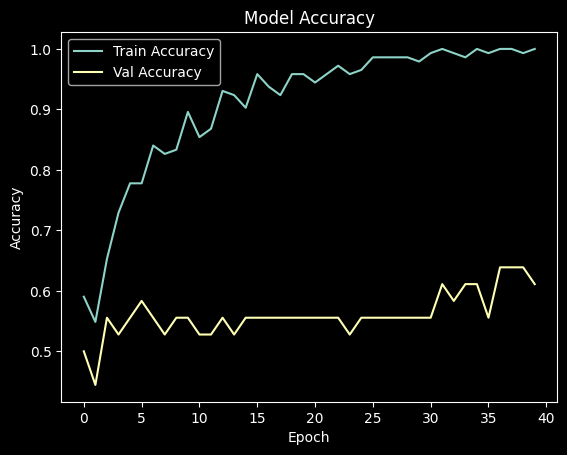

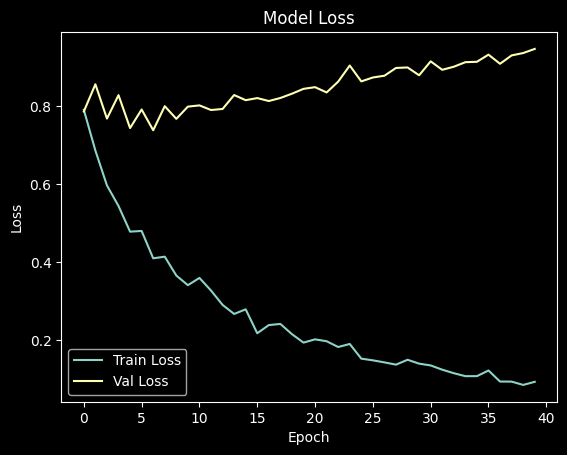

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_158']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


86.69% confidence this is test
Predicted Severity: Severe


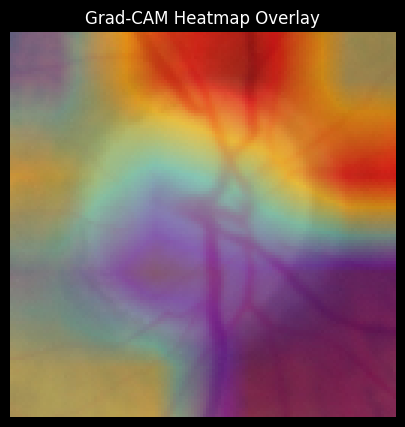

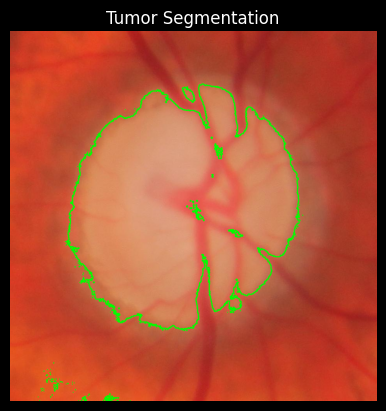

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install tensorflow

# %%
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import psutil

# System info
plt.style.use('dark_background')
print(f"RAM available: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

# Paths and parameters
data_dir = "/content/drive/MyDrive/dataset"
img_size = (128, 128)
batch_size = 8

# Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)

val_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False)

class_names = list(train_data.class_indices.keys())

# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# Build model
def build_model():
    base = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    # Change the number of units in the final dense layer to match the number of classes
    output = layers.Dense(len(class_names), activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=45, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=45, min_lr=1e-6)

# Train
history = model.fit(train_data, validation_data=val_data, epochs=40,
                    class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# Evaluate
loss, acc, prec, rec = model.evaluate(val_data)
print(f"Loss: {loss:.4f} | Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}%")

# Predictions
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Accuracy and loss plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# AUC-ROC
def plot_auc_roc(y_true, y_pred, class_names):
    n_classes = len(class_names)

    if n_classes == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='cyan', label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUC-ROC Curve (Binary Classification)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    else:
        # Multiclass classification
        y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.figure(figsize=(10, 8))
        plt.plot(fpr["micro"], tpr["micro"], linestyle=':', label='micro-average AUC = {:.2f}'.format(roc_auc["micro"]))
        plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label='macro-average AUC = {:.2f}'.format(roc_auc["macro"]))

        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUC-ROC Curve (Multi-Class)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()


# Tumor segmentation
def segment_tumor(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Segmentation')
    plt.axis('off')
    plt.show()

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1", pred_index=None):
    # Find the last convolutional layer dynamically
    last_conv_layer = None
    for layer in reversed(model.layers):
        # MobileNetV2's convolutional layers are typically of type DepthwiseConv2D or Conv2D
        if isinstance(layer, tf.keras.layers.DepthwiseConv2D) or isinstance(layer, tf.keras.layers.Conv2D):
             # We are looking for the last one in the base model before the classification head
            if 'global_average_pooling2d' in layer.output.name:
                continue  # Skip if it's part of the classification head, we want the last conv in the base
            last_conv_layer_name = layer.name
            break

    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            # Use the model's prediction to determine the target class index
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # Apply ReLU to the heatmap to only consider positive gradients
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    # Ensure heatmap is resized to the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Convert heatmap to 3 channels for color mapping
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    plt.figure(figsize=(10, 5))
    # Convert BGR to RGB for displaying with matplotlib
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap Overlay')
    plt.axis('off')
    plt.show()


# Predict + Segment + Explain
def predict_and_segment(image_path):
    img = Image.open(image_path).resize(img_size).convert("RGB")
    arr = np.array(img) / 255.0
    arr = arr.reshape(1, img_size[0], img_size[1], 3)

    res = model.predict(arr)
    class_idx = np.argmax(res[0])
    confidence = res[0][class_idx]
    # Assuming a simple mapping of confidence to severity, adjust as needed
    severity = "Severe" if confidence > 0.8 else "Moderate" if confidence > 0.5 else "Mild"

    print(f"{confidence*100:.2f}% confidence this is {class_names[class_idx]}")
    print(f"Predicted Severity: {severity}")

    # Ensure last_conv_layer_name is dynamically found or set correctly
    # For MobileNetV2, a common last convolutional layer before the pooling is 'Conv_1'
    # or you can find it programmatically as done in the make_gradcam_heatmap function
    # Alternatively, you can pass the correct layer name if you know it
    # For MobileNetV2, a name like 'Conv_1' from the original paper or similar is common
    # Let's use the dynamic finding within the function
    heatmap = make_gradcam_heatmap(arr, model) # The function now finds the layer name internally
    display_gradcam(image_path, heatmap)
    segment_tumor(image_path)

# Test with an image
predict_and_segment("/content/drive/MyDrive/dataset/test/glaucoma test/glaucoma_231.jpg")

RAM available: 10.22 GB
Found 144 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.3242 - loss: 1.0949 - precision: 0.3242 - recall: 0.3242 - val_accuracy: 0.8056 - val_loss: 0.5874 - val_precision: 0.8056 - val_recall: 0.8056 - learning_rate: 1.0000e-04
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.6454 - loss: 0.7339 - precision: 0.6454 - recall: 0.6454 - val_accuracy: 0.7778 - val_loss: 0.6095 - val_precision: 0.7778 - val_recall: 0.7778 - learning_rate: 1.0000e-04
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5415 - loss: 0.7025 - precision: 0.5415 - recall: 0.5415 - val_accuracy: 0.5833 - val_loss: 0.6812 - val_precision: 0.5833 - val_recall: 0.5833 - learning_rate: 1.0000e-04
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.6500 - loss: 0.5660 - precision: 0.6500 - recall: 0.6500 - val_accuracy: 0.6667 - val_loss: 0.6367 - val_precision: 0.6667 - val_recall: 0.6667 - learning_rate: 1.0000e-04
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accu

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step

Classification Report:
               precision    recall  f1-score   support

        test       0.67      0.25      0.36         8
       train       0.82      0.96      0.89        28

    accuracy                           0.81        36
   macro avg       0.74      0.61      0.62        36
weighted avg       0.78      0.81      0.77        36

Confusion Matrix:
 [[ 2  6]
 [ 1 27]]


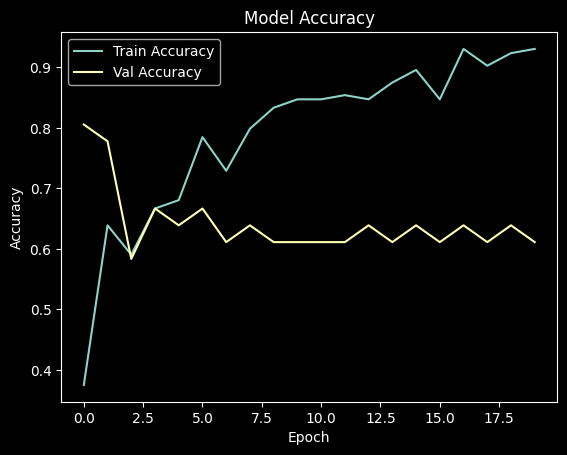

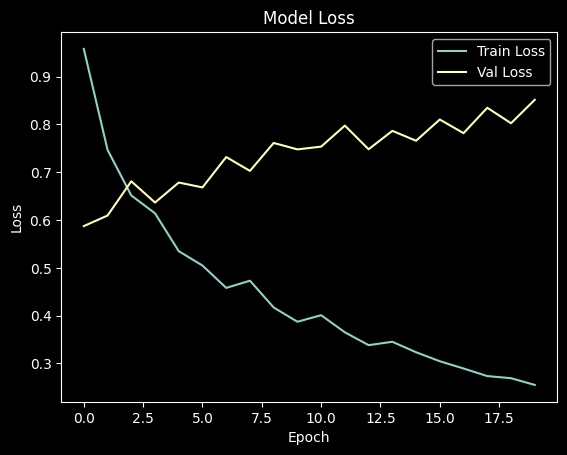

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
51.95% confidence this is train
Predicted Severity: Moderate


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_316']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


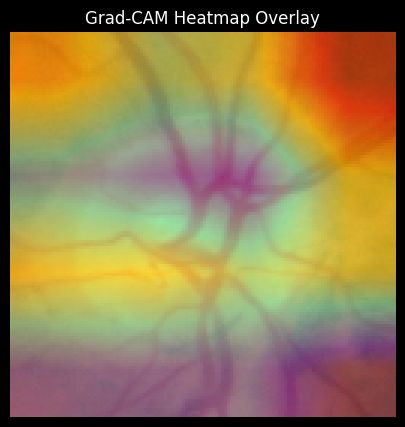

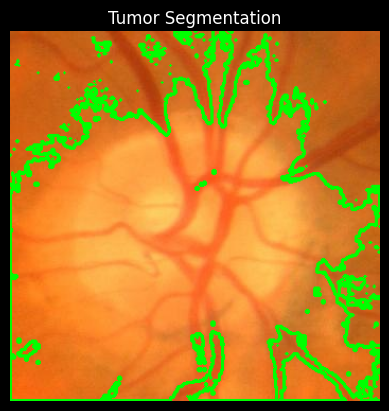

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
!pip install tensorflow

# %%
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import psutil

# System info
plt.style.use('dark_background')
print(f"RAM available: {psutil.virtual_memory().available / (1024 ** 3):.2f} GB")

# Paths and parameters
data_dir = "/content/drive/MyDrive/dataset"
img_size = (128, 128)
batch_size = 8

# Data Generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training', shuffle=True)

val_data = datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation', shuffle=False)

class_names = list(train_data.class_indices.keys())

# Class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# Build model
def build_model():
    base = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    # Change the number of units in the final dense layer to match the number of classes
    output = layers.Dense(len(class_names), activation='softmax')(x)
    return models.Model(inputs=base.input, outputs=output)

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=45, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=45, min_lr=1e-6)

# Train
history = model.fit(train_data, validation_data=val_data, epochs=20,
                    class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# Evaluate
loss, acc, prec, rec = model.evaluate(val_data)
print(f"Loss: {loss:.4f} | Accuracy: {acc*100:.2f}% | Precision: {prec*100:.2f}% | Recall: {rec*100:.2f}%")

# Predictions
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

# Accuracy and loss plots
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# AUC-ROC
def plot_auc_roc(y_true, y_pred, class_names):
    n_classes = len(class_names)

    if n_classes == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='cyan', label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUC-ROC Curve (Binary Classification)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    else:
        # Multiclass classification
        y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.figure(figsize=(10, 8))
        plt.plot(fpr["micro"], tpr["micro"], linestyle=':', label='micro-average AUC = {:.2f}'.format(roc_auc["micro"]))
        plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label='macro-average AUC = {:.2f}'.format(roc_auc["macro"]))

        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUC-ROC Curve (Multi-Class)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()


# Tumor segmentation
def segment_tumor(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(img, [contour], -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Tumor Segmentation')
    plt.axis('off')
    plt.show()

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1", pred_index=None):
    # Find the last convolutional layer dynamically
    last_conv_layer = None
    for layer in reversed(model.layers):
        # MobileNetV2's convolutional layers are typically of type DepthwiseConv2D or Conv2D
        if isinstance(layer, tf.keras.layers.DepthwiseConv2D) or isinstance(layer, tf.keras.layers.Conv2D):
             # We are looking for the last one in the base model before the classification head
            if 'global_average_pooling2d' in layer.output.name:
                continue  # Skip if it's part of the classification head, we want the last conv in the base
            last_conv_layer_name = layer.name
            break

    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            # Use the model's prediction to determine the target class index
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # Apply ReLU to the heatmap to only consider positive gradients
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    # Ensure heatmap is resized to the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Convert heatmap to 3 channels for color mapping
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    plt.figure(figsize=(10, 5))
    # Convert BGR to RGB for displaying with matplotlib
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Heatmap Overlay')
    plt.axis('off')
    plt.show()


# Predict + Segment + Explain
def predict_and_segment(image_path):
    img = Image.open(image_path).resize(img_size).convert("RGB")
    arr = np.array(img) / 255.0
    arr = arr.reshape(1, img_size[0], img_size[1], 3)

    res = model.predict(arr)
    class_idx = np.argmax(res[0])
    confidence = res[0][class_idx]
    # Assuming a simple mapping of confidence to severity, adjust as needed
    severity = "Severe" if confidence > 0.8 else "Moderate" if confidence > 0.5 else "Mild"

    print(f"{confidence*100:.2f}% confidence this is {class_names[class_idx]}")
    print(f"Predicted Severity: {severity}")

    # Ensure last_conv_layer_name is dynamically found or set correctly
    # For MobileNetV2, a common last convolutional layer before the pooling is 'Conv_1'++++
    # or you can find it programmatically as done in the make_gradcam_heatmap function
    # Alternatively, you can pass the correct layer name if you know it
    # For MobileNetV2, a name like 'Conv_1' from the original paper or similar is common
    # Let's use the dynamic finding within the function
    heatmap = make_gradcam_heatmap(arr, model) # The function now finds the layer name internally
    display_gradcam(image_path, heatmap)
    segment_tumor(image_path)

# Test with an image
predict_and_segment("/content/drive/MyDrive/dataset/test/normal test/normal_338.jpg")